# AnnNet Showcase — edges, interop, SBML, and `.annnet` I/O

This notebook demonstrates:
- constructing a graph with **all edge types** supported (binary directed/undirected, self-loops, parallel edges, vertex–edge links, and k‑ary hyperedges),
- quick inspection & visualization,
- running algorithms in **NetworkX (NX)** via the lazy proxy,
- importing a repressilator (Elowitz) model from **SBML (Systems Biology Markup Language)**,
- and saving/loading the lossless **`.annnet`** format.

> Tip: the `G.nx.<algo>(G, ...)` proxy builds a cached NX view of `G` on‑demand, and supports knobs like `_nx_simple=True` (collapse parallel edges) and `_nx_directed=False` (undirected view).


In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))

import annnet as an
import networkx as nx  # NX (NetworkX) algorithms
from pathlib import Path

print('annnet version:', an.__version__)

annnet version: 0.1.0


## 1) Build a demo graph with all edge types

In [5]:
G = an.Graph(directed=True)  # default direction; can be overridden per-edge

# Add vertices with attributes
G.add_vertices([
    ('A', {'name': 'a'}),
    ('B', {'name': 'b'}),
    ('C', {'name': 'c'}),
    ('D', {'name': 'd'}),
])

# 1) Binary directed
e_dir = G.add_edge('A', 'B', weight=2.0, edge_directed=True, relation='activates')

# 2) Binary undirected
e_undir = G.add_edge('B', 'C', weight=1.0, edge_directed=False, relation='binds')

# 3) Self-loop
e_loop = G.add_edge('D', 'D', weight=0.5, edge_directed=True, relation='self')

# 4) Parallel edge (same endpoints, different ID)
e_parallel = G.add_parallel_edge('A', 'B', weight=5.0, relation='alternative')

# 5) Vertex–edge link (edge-entity)
G.add_edge_entity('edge_e1', description='signal')
e_vx = G.add_edge('edge_e1', 'C', edge_type='vertex_edge', edge_directed=True, channel='edge->vertex')

# 6) Hyperedge (undirected, 3‑way)
e_hyper_undir = G.add_hyperedge(members=['A','C','D'], weight=1.0, tag='complex')

# 7) Hyperedge (directed, head->tail)
e_hyper_dir = G.add_hyperedge(head=['A','B'], tail=['C','D'], weight=1.0, reaction='A+B->C+D')

print('Vertices:', G.num_vertices, 'Edges:', G.num_edges)

Vertices: 4 Edges: 7


### Inspect edges (structured view)

In [8]:
ev = G.edges_view(include_directed=True, include_weight=True, resolved_weight=True)
ev

edge_id,kind,directed,global_weight,source,target,edge_type,head,tail,members,relation,channel,tag,reaction,effective_weight
str,str,bool,f64,str,str,str,list[str],list[str],list[str],str,str,str,str,f64
"""edge_0""","""binary""",true,2.0,"""A""","""B""","""regular""",null,null,null,"""activates""",null,null,null,2.0
"""edge_1""","""binary""",false,1.0,"""B""","""C""","""regular""",null,null,null,"""binds""",null,null,null,1.0
"""edge_2""","""binary""",true,0.5,"""D""","""D""","""regular""",null,null,null,"""self""",null,null,null,0.5
"""edge_3""","""binary""",true,5.0,"""A""","""B""","""regular""",null,null,null,"""alternative""",null,null,null,5.0
"""edge_4""","""binary""",true,1.0,"""edge_e1""","""C""","""vertex_edge""",null,null,null,null,"""edge->vertex""",null,null,1.0
"""edge_5""","""hyper""",false,1.0,null,null,null,null,null,"[""A"", ""C"", ""D""]",null,null,"""complex""",null,1.0
"""edge_6""","""hyper""",true,1.0,null,null,null,"[""A"", ""B""]","[""C"", ""D""]",null,null,null,null,"""A+B->C+D""",1.0


### Quick visualization via NX (NetworkX)

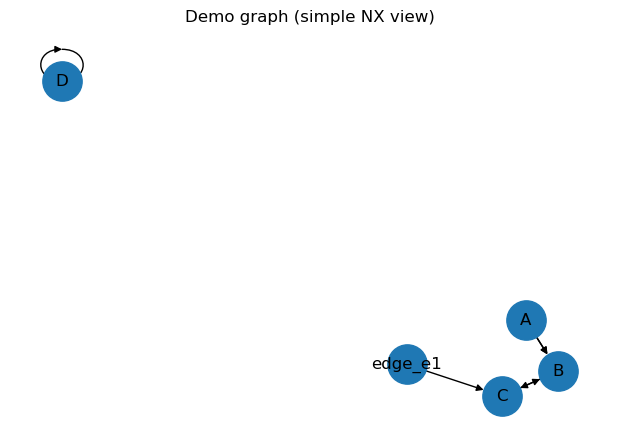

In [11]:
import matplotlib.pyplot as plt

# Obtain a simple NX view (collapse Multi* edges with sensible aggregations)
nxG, manifest = an.to_nx(G, directed=True, hyperedge_mode="skip")
pos = nx.spring_layout(nxG, seed=42)
plt.figure(figsize=(6,4))
nx.draw(nxG, pos, with_labels=True, node_size=800)
nx.draw_networkx_edge_labels(nxG, pos, edge_labels=nx.get_edge_attributes(nxG, 'weight'))
plt.title('Demo graph (simple NX view)')
plt.show()

## 2) Run a few NX (NetworkX) algorithms via the proxy

In [14]:
# Shortest path over weights (collapse parallel edges first)
sp_len = G.nx.shortest_path_length(G, source='A', target='D', weight='weight', _nx_simple=True)
sp = G.nx.shortest_path(G, source='A', target='D', weight='weight', _nx_simple=True)
print('Shortest path length A→D:', sp_len)
print('Shortest path A→D:', sp)

# Betweenness centrality (weighted)
bc = G.nx.betweenness_centrality(G, weight='weight', _nx_simple=True)
bc

Shortest path length A→D: 1.0
Shortest path A→D: ['A', 'D']


{'A': 0.0,
 'B': 0.0,
 'C': 0.41666666666666663,
 'D': 0.041666666666666664,
 'edge_e1': 0.0}

In [16]:
# Community detection using Label Propagation (works on undirected views)
comms = list(G.nx.asyn_lpa_communities(G, weight='weight', _nx_directed=False, _nx_simple=True))
comms

[{'A', 'B', 'C', 'D', 'edge_e1'}]

## 3) Interoperability (adapters)

In [21]:
# Top-level adapter function (returns NX graph; may also return a manifest in future)
nx_out = an.to_nx(G, directed=True, hyperedge_mode='expand')
nxG2 = nx_out[0] if isinstance(nx_out, tuple) else nx_out
assert isinstance(nxG2, (nx.Graph, nx.DiGraph, nx.MultiGraph, nx.MultiDiGraph))

# Optional: export to GraphML and SIF for demonstration
assets = Path('showcase'); assets.mkdir(exist_ok=True, parents=True)
an.to_graphml(G, assets/'demo.graphml')
an.to_sif(G, assets/'demo.sif')
str(assets.resolve())

'C:\\Users\\pc\\AnnNet\\docs\\showcase'

## 4) Import repressilator (Elowitz) from SBML

In [ ]:
# Path relative to this notebook (the repo includes docs/Elowitz.sbml.xml)
candidate_paths = [
    Path('Elowitz.sbml.xml'),
    Path('../Elowitz.sbml.xml'),
    Path('../../Elowitz.sbml.xml'),
    Path('../assets/Elowitz.sbml.xml'),
]
sbml_path = None
for p in candidate_paths:
    if p.exists():
        sbml_path = p; break
if sbml_path is None:
    # Fallback to repo root path when running notebook from project root
    alt = Path('docs/Elowitz.sbml.xml')
    sbml_path = alt if alt.exists() else None

print('SBML file:', sbml_path)
R = an.from_sbml(str(sbml_path)) if sbml_path else None
R

In [ ]:
if R is not None:
    print('Repressilator — vertices:', R.num_vertices, 'edges:', R.num_edges)
    R.edges_view().head(10)

## 5) Save & load the lossless `.annnet` format

In [ ]:
out_dir = Path('assets'); out_dir.mkdir(exist_ok=True, parents=True)
demo_path = out_dir/'demo.annnet'
sbml_path_out = out_dir/'repressilator.annnet'

G.write(demo_path)  # lossless save
print('Wrote:', demo_path)

# Round-trip check
G2 = an.Graph.read(demo_path)
print('Round-trip OK?', (G2.num_vertices, G2.num_edges) == (G.num_vertices, G.num_edges))

if R is not None:
    R.write(sbml_path_out)
    print('Saved repressilator to:', sbml_path_out)

---

### Notes
- `edges_view()` yields a compact, vectorized table of edges (including hyperedge metadata).
- For NX functions that require a **simple** graph (no parallel edges), pass `_nx_simple=True` and optionally `_nx_edge_aggs={'weight':'min','capacity':'sum'}`.
- You can also access an igraph view via `G.ig.<algo>(G, ...)` if **igraph** is installed.
- Lossless `.annnet` I/O: `Graph.write(path)` and `Graph.read(path)`.
